# Titanic Data Analysis

For P2 project I choose Titanic Dataset that contains demographics and passenger information from 891 of the 2224 passengers and crew on board the Titanic. According the description and analysis of this dataset the most interesting questions for me are:
- How many people from different passenger classes survived? Is it more likely to survive for passengers from 1st class? What factors made passengers more likely to survive?
- Is there a correlation between survival and age? 
- What prices people paid for better passenger classes? How much people were in different classes?

### Extracting data

In [67]:
import pandas as pd

filename = '/Users/Ulliwy/study/P2/project/titanic_data.csv'
titanic_data = pd.read_csv(filename)

In [68]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 1st question investigation
How many people from different passenger classes survived?
Firstly, the question is does it really more likely to survive for passengers in first class than for passengers in third class?

In [99]:
def calc_percentage(data, Pclass):                                   #calculating statistics according passenger class
    all_passengers = data.groupby(['Pclass']).get_group(Pclass)
    male = data[data.Sex == 'male'].groupby(['Pclass']).get_group(Pclass)
    female = data[data.Sex == 'female'].groupby(['Pclass']).get_group(Pclass)
    survived = data.groupby(['Pclass', 'Survived']).get_group((Pclass, 1))
    survived_percentage = (float(len(survived)) / float(len(all_passengers)))*100
    return survived_percentage, len(all_passengers), len(survived), len(female), len(male)

In [100]:
first_class_stat = calc_percentage(titanic_data, 1)
second_class_stat = calc_percentage(titanic_data, 2)
third_class_stat = calc_percentage(titanic_data, 3)

print 'Statistics per class:'
print '1st class: all {}, survived {}, female {}, male {}, percentage {:.2f}'.format(first_class_stat[1], first_class_stat[3], first_class_stat[4], first_class_stat[2], first_class_stat[0]),'%'
print '2nd class: all {}, survived {}, female {}, male {}, percentage {:.2f}'.format(second_class_stat[1], second_class_stat[3], second_class_stat[4], second_class_stat[2], second_class_stat[0]),'%'
print '3rd class: all {}, survived {}, female {}, male {}, percentage {:.2f}'.format(third_class_stat[1], third_class_stat[3], third_class_stat[4], third_class_stat[2], third_class_stat[0]),'%'

Statistics per class:
1st class: all 216, survived 94, female 122, male 136, percentage 62.96 %
2nd class: all 184, survived 76, female 108, male 87, percentage 47.28 %
3rd class: all 491, survived 144, female 347, male 119, percentage 24.24 %


According this statistics, it is noticed that there are more people from 1st class who survived. To find if there is really tendency for 1st class passengers to survive I'll perform test.

Question: is survival percentage for 1st class is higher than for 3rd class or not?
- Null hypothesis: the probability of survival for passengers from first class is lower or the same as for the passengers from third class.
- Alternative hypothesis: the probability of survival for passengers from 1st class is higher than for passengers from third class.

In this case I will treat this dataset as a sample (making investigation for purposes of inference and taking Titanic data sample to confirm or reject the hypothesis). As soon as there is no real population parameter such as mean value or standard deviation of a population and we only have a sample the t-test was chosen to find how different the percentage of survival for this two classes are. I’ll perform one-tailed test in positive direction with α = .05, this will allow to say if results are statistically significant.

In [102]:
import math

first_class = titanic_data.groupby(['Pclass']).get_group(1) #1st class passengers
mean_first_class = first_class['Survived'].mean()
std_first_class = first_class['Survived'].std()
print 'Survival probability in 1st class. Average: ', mean_first_class, ', std: ', std_first_class

third_class = titanic_data.groupby(['Pclass']).get_group(3) #3rd class passengers
mean_third_class = third_class['Survived'].mean()
std_third_class = third_class['Survived'].std()
print 'Survival probability in 3rd class. Average: ', mean_third_class, ', std: ', std_third_class

se = math.sqrt(((float(std_first_class)**2) / float(len(first_class))) + ((float(std_third_class)**2) / float(len(third_class))))
tstat = (mean_first_class - mean_third_class) / se #calc t-stat
print 't-stat value is: ', tstat

Survival probability in 1st class. Average:  0.62962962963 , std:  0.484025611327
Survival probability in 3rd class. Average:  0.242362525458 , std:  0.428949498646
t-stat value is:  10.1374169524


Result: these results are statistically significant. Reject null.

Conclusion: after statistical investigation it is possible to conclude that survival in first class is much higher than in third class, this result corresponds original hypothesis.

According this result there is more interesting question: does the survival really depend on a class? Or there were more factors that affected survival on Titanic? As we know during evacuation from the ship there were a priority for women and children to take place on lifeboats. To find this it is necessary to know: does survival depend on sex?

To test the hypothesis chi-squared test was chosen. The chi-squared test is used to determine whether there is a significant difference between the expected frequencies and the observed frequencies. Does the number of survived fall in each category (passenger class) differ significantly from the number that we expect? Is the distribution of survival rates across passengers in different classes differs from a uniform distribution in a statistically significant way. According this there are hypothesis:
- Null hypothesis: the survival doesn't really depend on passenger class.
- Alternative hypothesis: the survival depends on passenger class.

To test this, I'll perform chi-squared test with critical chi-squared value with p = .05.

In [103]:
def calc_chi_squared(group1, group2): #calculating test statistic according grouped values
    count_surv = group1.agg('count').iloc[:,0]
    count_vict = group2.agg('count').iloc[:,0]
   
    matrix = pd.concat([count_vict, count_surv], axis = 1).fillna(0)
    total_x = matrix.sum(axis=0)
    total_y = matrix.sum(axis=1)
    print 'Observed values: '
    print matrix

    m1 = pd.DataFrame(total_x)
    m2 = pd.DataFrame(total_y)
    expected = (m1.dot(m2.T)/float(total_x.values.sum())).transpose()
    print 'Expected values: '
    print expected
    
    stat = (matrix - expected)**2 / expected
    return stat.values.sum()

In [104]:
survived_grouped_by_sex = titanic_data[titanic_data.Survived == 1].groupby(['Sex'])
victims_grouped_by_sex = titanic_data[titanic_data.Survived == 0].groupby(['Sex'])
print 'Does survival depend on sex?'
print calc_chi_squared(survived_grouped_by_sex, victims_grouped_by_sex)


Does survival depend on sex?
Observed values: 
        PassengerId  PassengerId
Sex                             
female           81          233
male            468          109
Expected values: 
        PassengerId  PassengerId
Sex                             
female   193.474747   120.525253
male     355.525253   221.474747
263.050574071


Result: as soon as df = 1 and critical χ2 = 3.841 it is possible to reject null and make a conclusion that there is strong dependence between sex and survival. That totally confirms that there was a priority for women during evacuation.
Also I've performed that test to find dependence between passenger class and deck where passengers cabins were.

In [105]:
#grouped by pclass
survived_grouped_by_pclass = titanic_data[titanic_data.Survived == 1].groupby(['Pclass']) 
victims_grouped_by_pclass = titanic_data[titanic_data.Survived == 0].groupby(['Pclass'])

print 'Does survival depend on class?'
print calc_chi_squared(survived_grouped_by_pclass, victims_grouped_by_pclass)


Does survival depend on class?
Observed values: 
        PassengerId  PassengerId
Pclass                          
1                80          136
2                97           87
3               372          119
Expected values: 
        PassengerId  PassengerId
Pclass                          
1        133.090909    82.909091
2        113.373737    70.626263
3        302.535354   188.464646
102.888988757


Result: df = 2 and critical χ2 = 5.991. It is possible to make a conclusion that there is strong dependence on class for survival.

In [106]:
#to see is there a dependence between women and men among class
survived_males_by_pclass = titanic_data[(titanic_data.Survived == 1) & (titanic_data.Sex == 'male')].groupby(['Pclass'])
survived_females_by_pclass = titanic_data[(titanic_data.Survived == 1) & (titanic_data.Sex == 'female')].groupby(['Pclass'])

print 'Does survival depend on sex in class?'
print calc_chi_squared(survived_males_by_pclass, survived_females_by_pclass)

Does survival depend on sex in class?
Observed values: 
        PassengerId  PassengerId
Pclass                          
1                91           45
2                70           17
3                72           47
Expected values: 
        PassengerId  PassengerId
Pclass                          
1         92.654971    43.345029
2         59.271930    27.728070
3         81.073099    37.926901
9.37113933546


Result: df = 2 and critical χ2 = 5.991 it is possible to reject null. But as soon as critical value is not much less than statistical value there is a conclusion that although women had a priority over men to take place in lifeboat there still was some priority for men from first class than for men from 3rd class. Probably wealthy people can have just a little but still more advantages even during disaster.

Conclusion: according tests and data analysis there were found 2 main factors that made people more likely to survive: class and sex. There were strong advantage for women to get on lifeboards than for men and it didn't depend on what class women were from. But also according tests it is noticed that male passengers from 1st class still had some advantage over other male passengers to get on lifeboats. Probably during evacuation there were chaos and some people violated rule "women and children first" that's why there are more men from 1st class survived than from 2nd and 3rd.

There is still question: is there a dependency between deck where passengers' cabins and survival?

In [107]:
deck_series = titanic_data['Cabin'].dropna().apply(lambda deck: deck[0]) #first letter of cabin is deck name
m = pd.concat([titanic_data['Survived'], deck_series], axis = 1).dropna()
print 'Does survival depend on deck?'
print calc_chi_squared(m[m.Survived == 1].groupby('Cabin'), m[m.Survived == 0].groupby('Cabin'))

Does survival depend on deck?
Observed values: 
   Survived  Survived
A         8       7.0
B        12      35.0
C        24      35.0
D         8      25.0
E         8      24.0
F         5       8.0
G         2       2.0
T         1       0.0
Expected values: 
    Survived   Survived
A   5.000000  10.000000
B  15.666667  31.333333
C  19.666667  39.333333
D  11.000000  22.000000
E  10.666667  21.333333
F   4.333333   8.666667
G   1.333333   2.666667
T   0.333333   0.666667
10.3005563135


Result: according df=7 and critical χ2=14.067 it is possible to conclude that there was no dependency between survival and deck. Probably there were some time between collision with an iceberg and when ship has drowned so a lot of passengers could get deck with lifeboats. But there were a lot of gaps for cabin values in sample. And because of this our sample can't be very representative to say is there a real dependence between deck and survival.

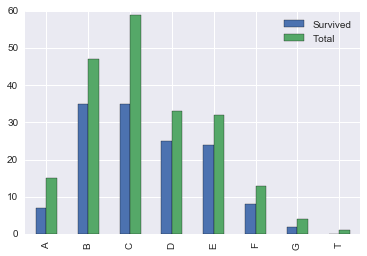

In [108]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

p = pd.concat([m[m.Survived == 1].groupby('Cabin').agg('count'), m.groupby('Cabin').agg('count')], axis=1).fillna(0)
p.columns = ['Survived', 'Total'];
p.plot(kind='bar')

As described on the graph there are similar values of survived passengers according all passengers. But for deck C and deck A the percent of survived passengers is a little lower than for other decks. After decks investigation I didn't notice any specific factors that can explain this result. According http://titanic.wikia.com/wiki/C_Deck there were cabins for all types of classes on deck C and on deck A there were only several luxury cabins for first class passengers. As it was said perhaps there are too much gaps in data to certainly say what deck passengers were more likely to survive.

### 2nd question investigation

Is there a correlation between age and survival?
As we know that during the evacuation there was a rule "women and children first". So is there a correlation between age and survival?

In [109]:
def correlation(x, y): #function for calculation correlation between two values
    mean_x = x.mean()
    std_x = x.std(ddof = 0)
    mean_y = y.mean()
    std_y = y.std(ddof = 0)
    standartized_x = (x - mean_x) / std_x
    standartized_y = (y - mean_y) / std_y
    correlation = standartized_x * standartized_y
    res = correlation.mean()
    return res

In [110]:
print 'Correlation between age and survival:'
print correlation(titanic_data['Age'], titanic_data['Survived']) #finding correlation between Age and Survival


Correlation between age and survival:
-0.0779826784139


Result: as soon correlation value is only -0.078 that means that data values for age and survival has weak correlation in negative direction. That means that these two values are not very related. To find out how normed distributions of age looks like there is a histogram.

(array([ 0.01559914,  0.00823288,  0.02729849,  0.02816511,  0.02253209,
         0.01039942,  0.0090995 ,  0.00389978,  0.        ,  0.00043331]),
 array([  0.42 ,   8.378,  16.336,  24.294,  32.252,  40.21 ,  48.168,
         56.126,  64.084,  72.042,  80.   ]),
 <a list of 10 Patch objects>)

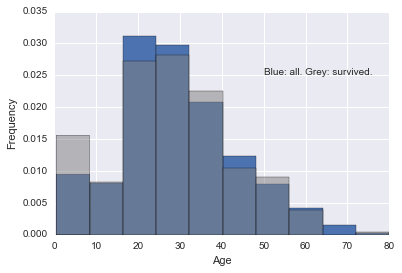

In [111]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

survived_grouped = titanic_data.groupby('Survived').get_group(1)

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.text(50, 0.025, 'Blue: all. Grey: survived.')
plt.hist(titanic_data['Age'].dropna(), normed = True)
plt.hist(survived_grouped['Age'].dropna(), normed = True, fc=(0.5, 0.5, 0.5, 0.5))

Conclusion: even there is no strong correlation between age and survival but we still can notice that distribution of ages for survived passengers a little different than age distribution among all passengers. And the frequency for small children is much higher for survived. According this observation, it is possible to conclude that children had more chances to get on lifeboats. And this results can confirm that rule "women and children first" worked.

### 3rd question investigation
According previous investigation we found that survival was depended on a class. So what prices people paid for tickets to different classes? What is the mean price for tickets for different classes?  How much people were in different classes?
To answer this questions statistic values were calculated according each class.

In [112]:
print 'Average price for 1st class ticket:',  first_class['Fare'].mean(), '. Max price: ', first_class['Fare'].max()
second_class = titanic_data.groupby(['Pclass']).get_group(2)
print 'Average price for 2nd class ticket:', second_class['Fare'].mean(), '. Max price: ', second_class['Fare'].max()
print 'Average price for 3rd class ticket:', third_class['Fare'].mean(), '. Max price: ', third_class['Fare'].max()


Average price for 1st class ticket: 84.1546875 . Max price:  512.3292
Average price for 2nd class ticket: 20.6621831522 . Max price:  73.5
Average price for 3rd class ticket: 13.6755501018 . Max price:  69.55


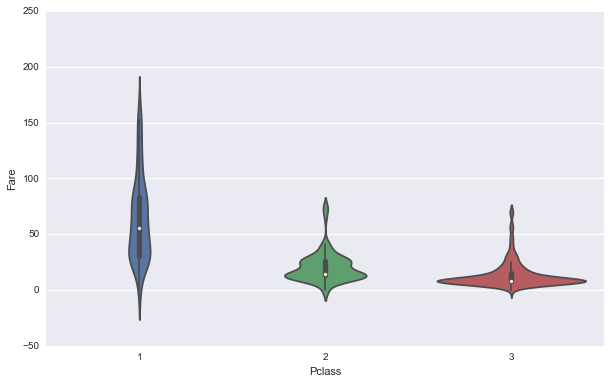

In [113]:
sorted_fare_first = titanic_data[['Fare', 'Pclass']]
a = sorted_fare_first[(sorted_fare_first.Fare-sorted_fare_first.Fare.mean()).abs()<3*sorted_fare_first.Fare.std()]

plt.figure(figsize = (10,6))
sns.violinplot(x='Pclass', y='Fare', data = a)

Conclusion: according this plot there was a big range for price for the first class, the average price for first class is 4 or more times higher than for 2nd and 3rd classes. The diagrams for 2nd and 3rd classes are not so stretches as for 1st class and looks similar vertically. On this graph we also see the difference between number of people. The largest was 3rd class, and there were not so much people in 1st class and especially who paid a lot for this voyage.

### Conclusion
The more I was investigating this data the more questions I've got. After several tests and Titanic disaster investigation and according data sample I've found several factors that made people more or less likely to survive and calculated interesting statistics about passengers on Titanic. As soon as there were a lot of discussions about this disaster and nobody really knows that exactly happened there still will be gaps in conclusions but even though there are some hypothesis that were confirmed. And according this results we can have an image of this terrible night.